In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import os
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers, backend
from tensorflow.keras.models import Model, Sequential
# from keras import backend

# Загрузка и распаковка фото

In [2]:
# @title Выбор источника данных {"run":"auto","vertical-output":true,"form-width":"50%","display-mode":"form"}
## @markdown Имя файла/архива с данными
# file_name = "NGF5NGG5.txt" # @param {"type":"string","placeholder":""}
#@markdown Источник загрузки котировок:
load_source = "Архивы с сайта a1069307.xsph.ru" # @param ["Архивы с сайта a1069307.xsph.ru","Архивы в сессионном хранилище (вручную)","Архивы с Гугл Диска"]
#@markdown Загружаемые архивы:
shov_file = True # @param {"type":"boolean","placeholder":"sddsf"}
noshov_sclice_file = True # @param {"type":"boolean","placeholder":"sddsf"}
noshov_file = True # @param {"type":"boolean","placeholder":"sddsf"}
centr_file = True # @param {"type":"boolean","placeholder":"sddsf"}
bok_file = True # @param {"type":"boolean","placeholder":"sddsf"}

Имена файлов-архивов и путей в локальном хранилище

In [3]:
# имена файлов
shov_fname = "shov.zip"
noshov_slice_fname = "noshov2.zip"
noshov_fname = "noshov.zip"
centr_fname = "centr.zip"
bok_fname = "bok.zip"

# пути к папам с извлеченными фото
path_train='/content/train'
path_test='/content/test'

In [ ]:
# получение файлов-архивов в сессионное хранилище и настройка путей к ним
if load_source=='Архивы с Гугл Диска':
  from google.colab import drive # Модуль для работы с Google Disk
  drive.mount('/content/drive')
  # использовать '\' для экранирования 'пробела' в пути
  path_on_drive="/content/drive/MyDrive/Colab\ Notebooks/"
  shov_fname=path_on_drive+shov_fname
  noshov_slice_fname=path_on_drive+noshov_slice_fname
  noshov_fname=path_on_drive+noshov_fname
  centr_fname=path_on_drive+centr_fname
  bok_fname=path_on_drive+bok_fname

elif load_source=='Архивы в сессионном хранилище (вручную)':
  shov_fname="/content/"+shov_fname
  noshov_slice_fname="/content/"+noshov_slice_fname
  noshov_fname="/content/"+noshov_fname
  centr_fname="/content/"+centr_fname
  bok_fname="/content/"+bok_fname

elif load_source=='Архивы с сайта a1069307.xsph.ru':
  # загрузка архивов с сайта в рабочую папку 'content\'
  if shov_file:
    !wget http://a1069307.xsph.ru/shov/original/shov.zip     # 31,8M
  if noshov_sclice_file:
    !wget http://a1069307.xsph.ru/shov/noshov2.zip           # 38M
  if noshov_file:
    !wget http://a1069307.xsph.ru/shov/original/noshov.zip;   # 57,8M
  if centr_file:
    !wget http://a1069307.xsph.ru/shov/original/centr.zip    # 15,6M
  if bok_file:
    !wget http://a1069307.xsph.ru/shov/original/bok.zip      # 2,5M

print('shov_fname=',shov_fname)
print('noshov_slice_fname=',noshov_slice_fname)
print('noshov_fname=',noshov_fname)
print('centr_fname=',centr_fname)
print('bok_fname=',bok_fname)

In [9]:
# распаковка из архивов (qq=без протокола, u=только новые, d=выходной путь)
if noshov_sclice_file:
  !unzip -qq -u $noshov_slice_fname -d $path_train
if centr_file:
  !unzip -qq -u $centr_fname -d $path_train
# bok после распаковки перенести в папку centr
if bok_file:
  !unzip -qq -u $bok_fname
  # переместить файлы bok в папку с centr
  destination = os.path.join(path_train, 'centr')
  for f in os.listdir('/content/bok'):
    src_path = os.path.join('/content/bok', f)
    dst_path = os.path.join(destination, 'bok'+f)
    os.rename(src_path, dst_path)

if shov_file:
  !unzip -qq -u $shov_fname -d $path_test
if noshov_file:
  !unzip -qq -u $noshov_fname -d $path_test

In [ ]:
# очистка/удаление папки (при необходимости)
# !rm -r '/content/train/bok'
# !rm -r '/content/train'
# !rm -r '/content/test'

In [10]:
data_dir = pathlib.Path(path_train)
data_dir

PosixPath('/content/train')

In [11]:
test_dir = pathlib.Path(path_test)
test_dir

PosixPath('/content/test')

In [12]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'В датасете для обучения {image_count} изображений')
image_count2 = len(list(test_dir.glob('*/*.jpg')))
print(f'В датасете для проверки {image_count2} изображений')

В датасете для обучения 11245 изображений
В датасете для проверки 2777 изображений


# Разделение фото на выборки

In [ ]:
batch_size = 32
img_height = 100
img_width = 100
# датасет для обучения
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11245 files belonging to 2 classes.
Using 8996 files for training.


In [ ]:
# вывод списка классов
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['centr', 'noshov']


In [ ]:
# индекс интересуемого класса 'centr' в списке классов (для последующей проверки)
index_centr = np.where(np.array(class_names) == 'centr')[0][0]

Пример изображения

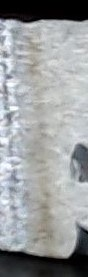

In [ ]:
selected_class = 'noshov'
selected_class = 'centr'
selected_imgs = list(data_dir.glob(f'{selected_class}/*'))
PIL.Image.open(str(selected_imgs[5]))

In [ ]:
# датасет для проверки
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11245 files belonging to 2 classes.
Using 2249 files for validation.


Просмотр примеров фото

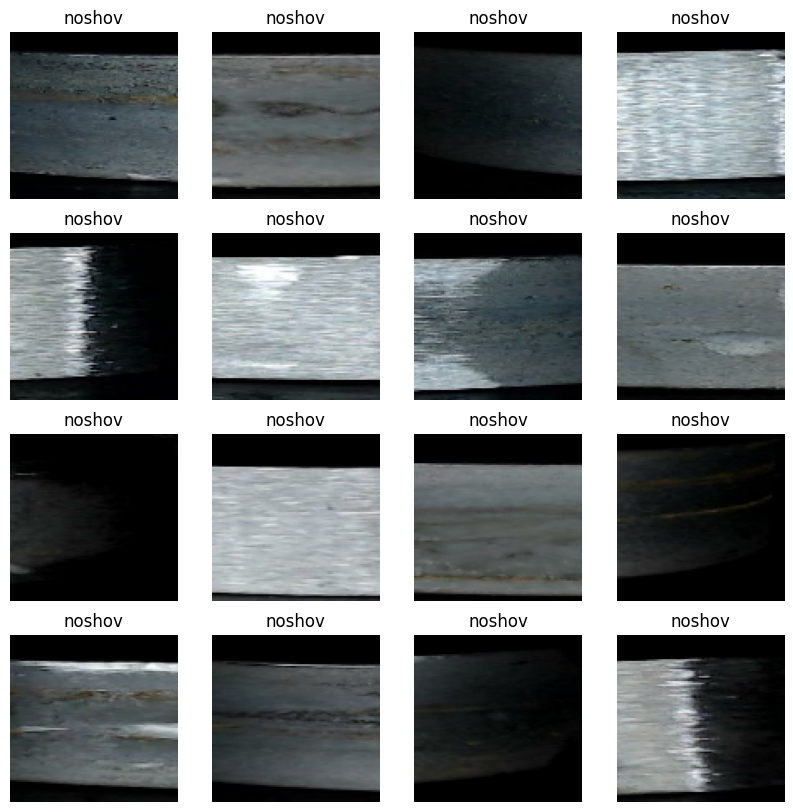

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
	for i in range(16):
		ax = plt.subplot(4, 4, i + 1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(class_names[labels[i]])
		plt.axis("off")

In [ ]:
#для кеширования изображений, чтобы они не подгружались в начале каждой эпохи обучения
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Задание и обучение нейронной сети

In [ ]:
# @title Выполнить загрузку обученной НС из файла? {"run":"auto","vertical-output":true,"display-mode":"form"}
loading_model = True # @param {"type":"boolean"}

In [ ]:
#имя файла НС модели
model_file="model_shov.keras"

In [ ]:
if loading_model:
  # проверить наличие файла в локальном хранилище
  full_model_file=os.path.join('/content',model_file)
  if not os.path.isfile(full_model_file):
    model_url=os.path.join('http://f1065011.xsph.ru/shov',model_file)
    !wget $model_url
    print('НС загружена из файла')
  else:
    print('файл НС уже в файловом хранилище')
  model = tf.keras.models.load_model(model_file)
else:
  backend.clear_session()
  model = Sequential()
  model.add(layers.Input(shape=(img_height, img_width, 3)))
  model.add(layers.Rescaling(1./255))
  model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(num_classes))
  #сборка модели
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

--2025-04-19 10:37:26--  http://f1065011.xsph.ru/shov/model_shov.keras
Resolving f1065011.xsph.ru (f1065011.xsph.ru)... 141.8.192.151
Connecting to f1065011.xsph.ru (f1065011.xsph.ru)|141.8.192.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14491130 (14M)
Saving to: ‘model_shov.keras’

model_shov.keras    100%[===================>]  13.82M  4.62MB/s    in 3.0s    

2025-04-19 10:37:29 (4.62 MB/s) - ‘model_shov.keras’ saved [14491130/14491130]

НС загружена из файла


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,610,856 (13.77 MB)

 Trainable params: 1,203,618 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,407,238 (9.18 MB)

In [ ]:
# обучение НС
if not loading_model:
  epochs=3
  history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Результаты обучения НС

In [ ]:
if not loading_model:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Точность обучения')
  plt.plot(epochs_range, val_acc, label='Точность на проверочных')
  plt.legend(loc='lower right')
  plt.title('Точность')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Потери на обучающих')
  plt.plot(epochs_range, val_loss, label='Потери на проверочных')
  plt.legend(loc='upper right')
  plt.title('Потери')
  plt.show()

## Проверка на отдельном фото

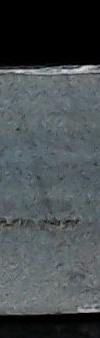

In [ ]:
# selected_class = 'centr'
selected_class = 'noshov'
test_img = list(data_dir.glob(f'{selected_class}/*'))[35]
PIL.Image.open(str(test_img))

In [ ]:
img = tf.keras.utils.load_img(test_img, target_size=(img_height, img_width))
#получить массив пикселей
img_array = tf.keras.utils.img_to_array(img) #Image в np.array [H, W, 3]
img_array = tf.expand_dims(img_array, 0) # np.array расширить до тензора [1, H, W, 3]
#получение прогноза
predictions = model.predict(img_array, verbose='no')
score = tf.nn.softmax(predictions[0])
max_ind=np.argmax(score)
print("класс '{}' с вероятностью {:.2f} %".format(class_names[max_ind], 100 * score[max_ind]))
display(pd.DataFrame({'cls':class_names,'sc':score}))

класс 'noshov' с вероятностью 100.00 %


,cls,sc
0,centr,1.802486e-07
1,noshov,9.999998e-01


## Расширение выборки (закомментировано)

In [ ]:
# data_augmentation = keras.Sequential(
#   [
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1)
#   ]
# )

In [ ]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

In [ ]:
# backend.clear_session()
# model = Sequential([
#   data_augmentation,
#   layers.Rescaling(1./255),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes, name="outputs")
# ])

In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
# epochs = 10
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Точность обучения')
# plt.plot(epochs_range, val_acc, label='Точность на проверочных')
# plt.legend(loc='lower right')
# plt.title('Точность')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Потери на обучающих')
# plt.plot(epochs_range, val_loss, label='Потери на проверочных')
# plt.legend(loc='upper right')
# plt.title('Потери')
# plt.show()

In [ ]:
# PIL.Image.open(str(test_img))

## Сохранение модели в файл

In [ ]:
if not loading_model:
  model.save("model_shov.keras")
  print('НС сохранена в файл')

# Проверка НС на широких фото

## Используемые функции

In [ ]:
from PIL.Image import Resampling

# Нарезать фото (image) на части шириной (sub_width) с шагом (stride)
def slice_image(image, sub_width, stride):
  SUB_HEIGHT=image.height
  sub_imagesH=[]
  sub_images=[]
  sub_count=1+(image.width-sub_width)//stride
  for x in range(sub_count):
    sub_imagesH.append(image.crop((x*stride, 0, x*stride + sub_width, SUB_HEIGHT)))
    sub_images.append(image.resize((img_height, img_width),
                                   resample= Resampling.BILINEAR,
                                   box=(x*stride, 0, x*stride + sub_width, SUB_HEIGHT)))
  return (sub_images, sub_imagesH)

In [ ]:
# вывод картинок с заголовками в 1 ряд
def show_images(subs, titles, sub_score, fontsize=10):
  count_subs=len(subs)
  plt.figure(figsize=(12, 4))
  for i in range(count_subs):
    axs = plt.subplot(1, count_subs,i+1)
    plt.imshow(subs[i])
    plt.title(titles[i],fontsize=fontsize)
    plt.axis("off")

  fig, ax = plt.subplots(figsize=(12, 2))
  plt.plot(100*sub_score.numpy())
  plt.title('Вероятность шва от номера сегмента фото');
  xticks = np.arange(0, count_subs, 1)
  ax.set_xticks(xticks)
  # yticks = np.arange(0, 100, 5)
  # ylabels = [f'{x:1.0f}%' for x in yticks]
  # ax.set_yticks(yticks, labels=ylabels)

  plt.show()
  plt.close()

In [ ]:
# получить фото по классу и индексу + возможность показать (---)
def selectImage(selected_class, ind, to_display=False):
  path_test_img = list(test_dir.glob(f'{selected_class}/*'))[ind]
  img = PIL.Image.open(str(path_test_img))
  if to_display:
    print('Размер фото',img.size)
    display(img)
  return img

In [ ]:
test_dir

PosixPath('/content/test')

In [ ]:
# Предсказывает вероятность для сегментов одного фото и отображает их
def predictOnePhoto(image, SUB_WIDTH, stride, model, to_display=False):
    """
    Аргументы:
      image: изображение для прогноза
      SUB_WIDTH: ширина сегмента фото
      stride: шаг сдвига сегмента фото
      model: обученная модель Keras для предсказания
      to_display: надо ли выводить графические результаты прогноза
    Возвращает:
      sub_score: numpy-массив предсказанных вероятностей для 'centr' для каждого сегмента
    """
    sub_images,sub_imagesH = slice_image(image, SUB_WIDTH, stride)

    # Определяем количество сегментов
    sub_count = len(sub_images)

    # Преобразуем каждый сегмент в массив numpy с помощью keras.utils.img_to_array.
    # Это необходимо для корректной подачи данных в модель.
    sub_tf = [keras.utils.img_to_array(sub_images[i]) for i in range(sub_count)]

    # Выполняем предсказание для всех сегментов сразу (батч) с использованием модели.
    # tf.convert_to_tensor преобразует список массивов в единый тензор.
    predictions = model.predict_on_batch(tf.convert_to_tensor(sub_tf))

    # Применяем функцию softmax к предсказаниям, чтобы получить вероятности по классам.
    score = tf.nn.softmax(predictions)

    # Извлекаем вероятности для данного класса для каждого сегмента.
    sub_score = score[:, index_centr]

    if to_display:
      # Вывод максимальной вероятности из полученных значений (в процентах).
      print(f'макс. вероятность шва на фото={max(sub_score.numpy())*100:3.1f}%')

      # Для каждого сегмента формируем строку с процентным значением вероятности.
      title_score = ["{:.2f} %".format(100 * x) for x in sub_score]

      # Отображаем сегменты и соответствующие заголовки с вероятностями.
      show_images(sub_imagesH, title_score, sub_score)

    # Возвращаем массив вероятностей для возможного дальнейшего использования.
    return sub_score


## Параметры нарезки фото

In [ ]:
SUB_WIDTH = 100   # ширина сегмента фото (50!)
stride = 50       # шаг сдвига сегмента фото

## Проверка на одном фото

### Загрузка фото и нарезка на части

In [ ]:
selected_class='shov' # класс фото
num_sample = 21       # номер фото в списке

Размер фото (711, 338)


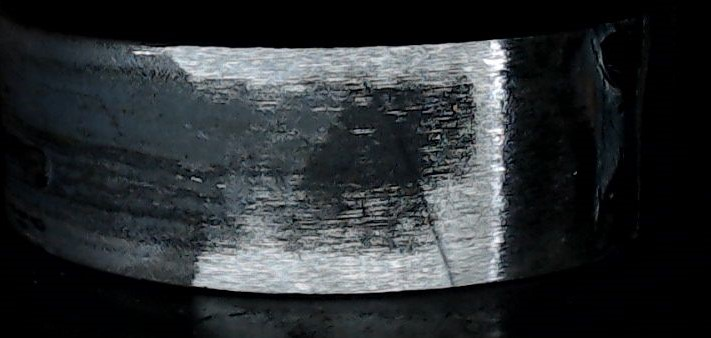

In [ ]:
img=selectImage(selected_class, num_sample, to_display=True)

Нарезать фото на части

фрагмент #1 сжатый: (100, 100)


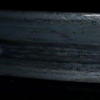

фрагмент #1 оригинальный: (100, 338)


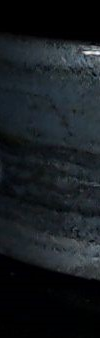

In [ ]:
sub_images,sub_imagesH = slice_image(img, SUB_WIDTH, stride)
sub_count=len(sub_images)

num_sample_img =1
print('фрагмент #'+str(num_sample_img),'сжатый:',sub_images[0].size)
display(sub_images[num_sample_img])
print('фрагмент #'+str(num_sample_img),'оригинальный:',sub_imagesH[0].size)
display(sub_imagesH[num_sample_img])

### Прогноз на нарезанных фото

макс. вероятность шва на фото=9.5%


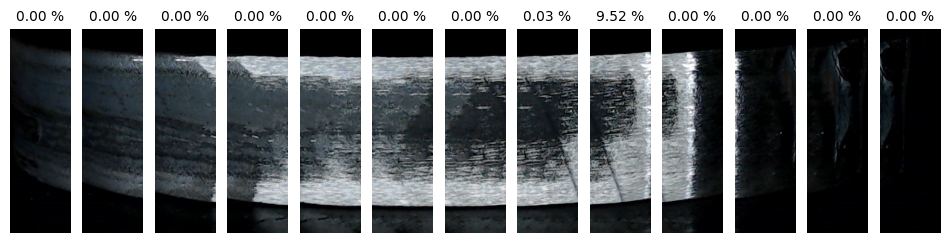

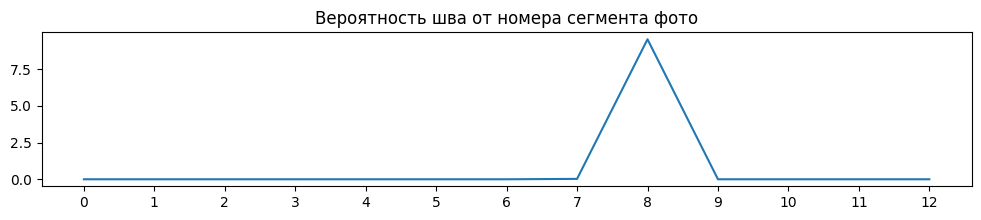

In [ ]:
subScore = predictOnePhoto(img, SUB_WIDTH, stride, model, to_display=True)
# sub_score

## Проверка на нескольких фото

In [ ]:
# @title Загрузить расчитанные ранее результаты проверки? {"run":"auto"}
loading_test = True # @param {"type":"boolean"}


In [ ]:
def predict_all_image_from_folder(dir_path, count_predict=-1):
  ResultList = []
  i=0
  for fname in os.listdir(dir_path):
    full_fname = os.path.join(dir_path, fname)
    img = PIL.Image.open(full_fname)
    subScore = predictOnePhoto(img, SUB_WIDTH, stride, model)
    score = subScore.numpy()
    ResultList.append({
        'filename': full_fname,
        'max_p': max(score)*100,
        'max_num': np.argmax(score),
        'sub_scores': score
        })
    i+=1
    if count_predict!=-1 and i>=count_predict: break
  return ResultList

In [ ]:
result_fname='result_list.csv'
if loading_test:
  result_df = pd.read_csv(result_fname)
else:
  ResultList = predict_all_image_from_folder(test_dir.joinpath('shov'),3)
  result_df = pd.DataFrame(ResultList)
  result_df.to_csv(result_fname)
  from google.colab import files # Модуль для работы с Google Disk
  files.download(result_fname)
len(result_df)

3

## Анализ данных по налиию шва

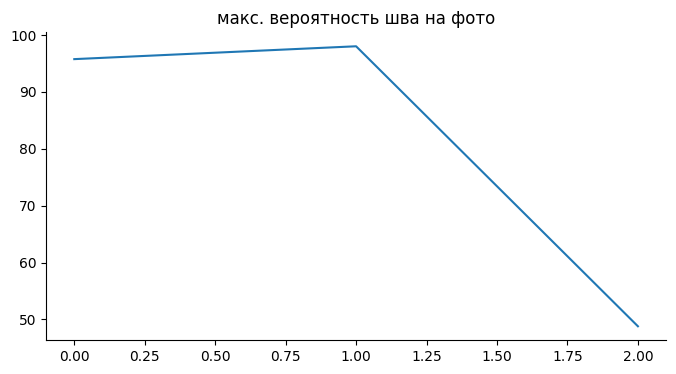

In [ ]:
result_df['max_p'].plot(kind='line', figsize=(8, 4), title='макс. вероятность шва на фото')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
result_df.head()

,Unnamed: 0,filename,max_p,max_num,sub_scores
0,0,/content/test/shov/427.jpg,95.75857,2,[9.8010640e-20 2.3814842e-10 9.5758569e-01 8.7...
1,1,/content/test/shov/496.jpg,98.01780,5,[1.7606076e-14 8.6919103e-09 9.5876399e-04 1.4...
2,2,/content/test/shov/18.jpg,48.79456,2,[3.8339118e-18 7.3667514e-05 4.8794559e-01 2.0...


In [ ]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    767 non-null    object 
 1   max_p       767 non-null    float32
 2   max_num     767 non-null    int64  
 3   sub_scores  767 non-null    object 
dtypes: float32(1), int64(1), object(2)
memory usage: 21.1+ KB


In [ ]:
common_count=result_df.shape[0]
print(common_count)
df2=result_df[result_df.max_p>50]
select_count=df2.shape[0]
print(select_count)
print(select_count/common_count)

767
434
0.5658409387222947


In [ ]:
df2

,filename,max_p,max_num,sub_scores
0,/content/test/shov/427.jpg,95.758568,2,"[9.801064e-20, 2.3814842e-10, 0.9575857, 0.872..."
1,/content/test/shov/496.jpg,98.017799,5,"[1.7606076e-14, 8.69191e-09, 0.000958764, 0.01..."
3,/content/test/shov/455.jpg,99.322960,5,"[1.1852776e-19, 6.459026e-11, 0.0010084506, 0...."
4,/content/test/shov/521.jpg,95.431534,3,"[4.217094e-18, 6.24961e-08, 0.6621264, 0.95431..."
5,/content/test/shov/489.jpg,96.084419,7,"[2.782039e-18, 1.8753576e-07, 0.0041654496, 0...."
...,...,...,...,...
760,/content/test/shov/430.jpg,91.373512,7,"[1.3978524e-13, 1.2037968e-06, 0.0015561515, 0..."
761,/content/test/shov/409.jpg,99.592300,7,"[5.2720245e-15, 1.9109734e-09, 0.0010768684, 0..."
762,/content/test/shov/230.jpg,97.279190,3,"[1.3362468e-20, 3.8571807e-13, 0.5406221, 0.97..."
765,/content/test/shov/355.jpg,85.490128,5,"[5.066262e-17, 1.2192154e-08, 0.0068568056, 0...."
